In [20]:
#from google.colab import drive
#drive.mount('/content/drive')

# Procesamiento de Lenguaje Natural (NLP): Análisis (clasificación) de sentimientos

In [21]:
#%pip install git+https://github.com/erikavaris/tokenizer.git

In [43]:
import string

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay, precision_score, recall_score, f1_score

from tokenizer import tokenizer as tk


In [44]:
pd.set_option('display.max_colwidth', None)

In [45]:
# Descargando las stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Gabriel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [46]:
# Función para tokenizar los comments
def tokenizer(text):
    rt = tk.RedditTokenizer()
    return rt.tokenize(text)

### Loading comments

In [47]:
comments_df = pd.read_csv('SuicidiosProyecto_clean.csv', sep = ',', names = ['id','text','class'], index_col='id',header = 1)




In [48]:
comments_df.shape

(195682, 2)

In [49]:
comments_df.sample(5)

,text,class
id,,
206771,feari ve been struggling with depression on and off since i was in middle school i ve always felt like i was alone and that i d never be happy i ve thought about how i would want to go when i would do and how to but i ve never gotten to actually try because i m just so scared to die i don t know of death could somehow be worse then life and i ve held out hope that maybe things could get better and they did i met the most wonderful woman in the world she made me feel things i thought i never would joy excited hopeful and she s made me feel that way everyday for the past months but because of certain things that have happened between us i m starting to feel like i lost my chance to be happy with her and i don t think she loves me anymore all of my friends are her friends that she introduced me too i hate my family and ive even tried several hotlines but sit through two minutes of automated dialogue makes me lose the courage i built up to even call in the first place if my fears turn out to be real and we split up then i ll know that the best part of my life is behind me and there won t be anything left keeping me from just ending all i want is to spill all my thoughts out to her and have her tell me everything will be okay but if i did that and she stayed it wouldn t be because she loved me it would be out of pity i don t know if typing this has made me feel better or worse but either way i probably won t check this again,suicide
166990,how do i do this i will stay up til like am every night and still act like a got a full hours im confused,non-suicide
299770,we live in a society i mean holy fuck that s deep let that sink in,non-suicide
152172,girlfriend left me after i gave up my life for her no reason to live anymore the only reason i had to live left me yesterday said our relationship want fair to me so she broke up with me i m going to die alone whether it be today tomorrow or in a few years,suicide
81699,i lost another one of my friendsi was having a bad day so i just decided id make all my friends hate me and it worked at least for one they didnt even send a last picture of their cat i feel like if i dont kill my self its a waste of losing them they were really nice to me i just ruined everything also i wish i could just throw my phone out all it does is make me sad and distract me at the same time,suicide


In [50]:
comments_df['class'].value_counts(dropna = False, normalize = True)

non-suicide    0.562898
suicide        0.437102
Name: class, dtype: float64

### Filtrando los comments que aún no han sido etiquetados

In [51]:
comments_labeled_df = comments_df.loc[comments_df['class'].notnull()]

In [52]:
# comments a ser usados para entrenar y evaluar el modelo
comments_labeled_df.shape

(195682, 2)

In [53]:
# comments descartados debido a que no se encuentran etiquetados
comments_df.loc[comments_df['class'].isnull()].shape

(0, 2)

In [54]:
# Scenario 1: Treating neutral as suicide classes
#comments_labeled_df['class'] = comments_labeled_df['class'].replace({'neutral': 'suicide'})

# Scenario 2: Working only with suicide and non-suicide classes
# Removing neutral class
comments_labeled_df = comments_labeled_df.loc[comments_labeled_df['class'].isin(['suicide', 'non-suicide'])]

# Scenario 3: Working with all classes

In [55]:

comments_labeled_df['class'].value_counts(dropna = False, normalize = True)

non-suicide    0.562898
suicide        0.437102
Name: class, dtype: float64

### Diviendo los comments etiquetados en los conjuntos de entrenamiento y prueba

In [56]:
# El parámetro 'stratify' es útil para asegurar que ambos conjuntos de datos queden aproximadamente balanceados
# Cuando se cuenta con muy pocos datos etiquetados, por lo general se debe disponer de una menor cantidad de datos para evaluación
X_train, X_test, y_train, y_test = train_test_split(comments_labeled_df['text'], comments_labeled_df['class'], test_size = 0.35, stratify = comments_labeled_df['class'], random_state = 1)

In [57]:
X_train.shape

(127193,)

In [58]:
pd.Series(y_train).value_counts(normalize = True)

non-suicide    0.5629
suicide        0.4371
Name: class, dtype: float64

In [59]:
X_test.shape

(68489,)

In [60]:
pd.Series(y_test).value_counts(normalize = True)

non-suicide    0.562893
suicide        0.437107
Name: class, dtype: float64

### Vectorizando los comments

<table>
    <tbody>
        <tr>
            <td>
                <h4>Bag of Words</h4>
                <img src="./imgs/bow.png" style="width: 500px;">
            </td>
            <td>
                <h4>TF-IDF</h4>
                <img src="./imgs/tf-idf.png" style="width: 500px;">
            </td>
        </tr>
    </tbody>
</table>

In [62]:
X_train.head()

id
322468    last person to care dropped mei was just told by my last real friend to not call or text or have anything to fo with him because he was tired of my depression and when i could act normal then he would talk to me again i don t know what to do anymore
331765                                                                                                                      so guys i told my crush i liked her update she hasn t said if she likes me back but i m hopeful because she keeps dropping subtle hints
281797          carbon monoxidejust curious here but i spent a total of hours with a tarp over the exhaust of my car while i slept to try to end it but i still woke up fine curious as how that happens i figured that long was way more then enough to do the job
35826                                          death won t stop be appealing to mei still cannot get over death having more appeal to me than life nothing is good enough here none of it is enough at least in death i w

In [65]:
tfidf = TfidfVectorizer(tokenizer = tokenizer, stop_words = stop_words, lowercase = True)

In [66]:
X_tfidf = tfidf.fit_transform(X_train.values.astype('U'))

In [67]:
len(tfidf.vocabulary_)

107342

### Entrenamiento de un modelo SVM


In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
lr_model = LogisticRegression(class_weight = "balanced")

In [70]:
lr_model.fit(X_tfidf, y_train)

LogisticRegression(class_weight='balanced')

In [71]:
y_train_svm_predict = lr_model.predict(X_tfidf)

In [72]:
X_test_tfidf = tfidf.transform(X_test.values.astype('U'))

In [ ]:
type(X_tfidf)

In [73]:
y_test_svm_predict = lr_model.predict(X_test_tfidf)

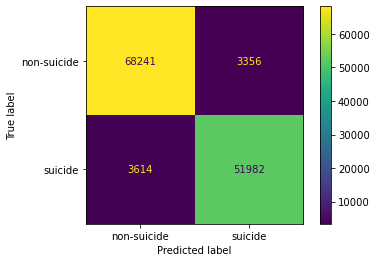

In [74]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_svm_predict)

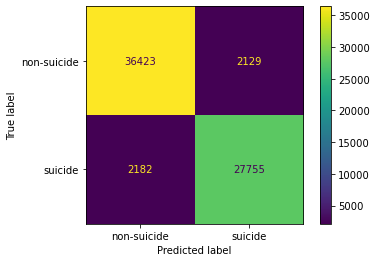

In [75]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_svm_predict)

In [76]:
if len(lr_model.classes_) == 2:
    print('Precision:', precision_score(y_train, y_train_svm_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_train, y_train_svm_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_train, y_train_svm_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_train, y_train_svm_predict, average = None))
    print('Recall:', recall_score(y_train, y_train_svm_predict, average = None))
    print('F1:', f1_score(y_train, y_train_svm_predict, average = None))

Precision: 0.9393545122700495
Recall: 0.9349953234045615
F1: 0.9371698487388899


In [78]:
if len(lr_model.classes_) == 2:
    print('Precision:', precision_score(y_test, y_test_svm_predict, pos_label = 'suicide'))
    print('Recall:', recall_score(y_test, y_test_svm_predict, pos_label = 'suicide'))
    print('F1:', f1_score(y_test, y_test_svm_predict, pos_label = 'suicide'))
else:
    # Para casos no binarios, es común calcular las métricas para cada clase
    print('Precision:', precision_score(y_test, y_test_svm_predict, average = None))
    print('Recall:', recall_score(y_test, y_test_svm_predict, average = None))
    print('F1:', f1_score(y_test, y_test_svm_predict, average = None))

Precision: 0.9287578637397939
Recall: 0.9271136052376657
F1: 0.9279350061015362


In [ ]:
X_bow_lr = bow.fit_transform(X_train.values.astype('U'))

In [ ]:
lr_model = LogisticRegression(class_weight = "balanced")

In [ ]:
lr_model.fit(X_bow_lr, y_train)

In [ ]:
y_train_lr_predict = lr_model.predict(X_bow_lr)

In [ ]:
X_test_lr = bow.fit_transform(X_test.values.astype('U'))

In [ ]:
y_test_lr_predict = lr_model.predict(X_test_lr)

### Análisis del error

In [80]:
error_df = pd.concat(
    [ pd.concat([X_test, y_test], axis = 1).reset_index(),
    pd.Series(y_test_svm_predict) ]
, axis = 1).rename(columns = { 'class': 'actual', 0: 'predicted' })

error_df.drop('id', inplace = True, axis = 1)

In [81]:
error_df.loc[error_df['actual'] != error_df['predicted']].shape

(4311, 3)

In [82]:
error_df.loc[error_df['actual'] != error_df['predicted']].sample(10)

,text,actual,predicted
8153,does anyone need to talk i feel like playing therapist right now and i want to help people so hmu if you need it,non-suicide,suicide
44654,good morning usa my life is falling apart fast and it s not fucking ok the sun in the sky has gun in my face i wish he d pull the trigger to take me away from this place oh boy it s swell to say i hate my fucking liiiiiiiiiiiiiiiiiiiiiife i hate my fucking liiiiiiiiiiiiiiife,non-suicide,suicide
18808,life is limitless chaos is it possible to slit your own throat yo,suicide,non-suicide
11695,april or may is when ill goive also said i would love until my cat died i guess i lied to myself im leaving in april or may i dont know how probably by overdosing ill leave a note to my parents telling them to check my phone and go to this account and read my posts and mom if you did then im sorry but i didnt want this anymore,suicide,non-suicide
66006,high school sucks seriously for the last years ive been in an absolute hellhole known as high school the majority of people in this school hate me i feel for virtually no reason i look into peoples eyes and all i see back is either hatred or snarkyness everyone feels so over the top about how they are better than me there are days where i am fine being at the bottom of the high school structure though there are days where i just hate every single fucking high schooler from what they have done from how they act about things the insults they come up with i hate this damn school i hate it with all the fiber of my being im not alone some days i feel like fucking screaming in everyones face the people that rub it in that im at the bottom i try my best to do things to get on top but i will never join it and i fucking hate it all,non-suicide,suicide
30071,year countdown started a few months ago the day i purchase a leader bike and go to a motorway is years from now i couldn t be more fearful and relieved i hope not to hurt anyone in the process if i wear a dnr wristband in case i make it will they comply,suicide,non-suicide
28298,what do you do when no one relates to you when you feel all alone with your thoughts,non-suicide,suicide
33844,i think there is something wrong with me so for the last few weeks i feel really tried and i struggle to get out of bed everyday i stopped attending my online classes and just gave up on most of them i haven t spoken to any of my friends in a month and i have completely stopped talking to my parents as well despite living in the same house i have no idea about what s wrong with me and i might have only felt this way once or twice before i feel like i am going through a major slump and i should just give up and sleep for eternity sometimes i wish i could cry but it doesn t come out ever sometimes i inflict physical pain so that i can start crying i just want to feel something again i want to feel happy i want to laugh but i can t i dont know why but i feel like i dont deserve to be happy i want to be able to work again just do something and be someone i want to go out and breathe fresh air but something inside of me stops me from going out ever time i get ready to go out i feel like i might not come back home alive i stare at the wall for hours together not thinking about anything i feel like i should be reaching out for help or something but there s no one close to me who i could bother with my troubles i also have become very impulsive for some reason just the other i woke up randomly at am and climbed my wardrobe and jumped from the top of it and broke a tile i get jitters and i run around the house for mins non stop or just learn a new ice skating program just to replicate it in my room i wish i could be happy again,non-suicide,suicide
54699,feels like vomiting im having a bad day today and i really dont feel good im trying to relax and all tht but my mind is racing not even animal collective could calm me down whatevrrrrrr im gonna go try to take a nap and wake up feeling better byeeeee,non-suicid